In [14]:
import networkx as nx
import numpy as np
import pandas as pd
import datetime
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# from utils import *
from read_networks import read_combined_graph_from_csv, read_citation_graph_from_edgelist


In [15]:
class GraphClass:
    """
    Class to et attributes matrix for experiment
    """
    # ==== Note: If you change a line here, please check if there's a corresponding line to be updated in the same way in ExperimentClass.add_edges_and_update ==== 
    def __init__(self, graph):
        # print(graph)
        self.graph = graph

        # create adjacency matrix
        self.adj_matrix = nx.to_numpy_array(self.graph)

        # == nodes ==
        # degree
        self.degrees = self.adj_matrix.sum(axis=1).reshape((-1, 1))

        # opinion
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

        # conformity
        self.conformity = np.array(list(nx.get_node_attributes(self.graph, "conformity").values())).reshape((-1, 1))

        # node_centrality
        self.node_centrality = np.array(list(nx.get_node_attributes(self.graph, "node_centrality").values())).reshape((-1, 1))
        
        # == edges ==
        # weight on edges
        self.weight = nx.attr_matrix(self.graph, edge_attr='weight')[0]

In [16]:
class GraphAttributeClass:
    """
    Class to add node/edges attribute to graph
    """
    def __init__(self, random_seed=42):
        np.random.seed(random_seed)

    def add_node_attr_opinion(self):
        """
        Initialize with a given timpstamp.
        If nodes are connected before this timestamp, they share a same init opinion.
        """
        for node in self.g.nodes:
            self.g.nodes[node]['opinion'] = 0

        # If nodes are connected before this timestamp, they share a same init opinion.
        for node in self.g.nodes:
            has_opinion_flag = False
            for init_nbr in self.g.neighbors(node):
                if self.g.nodes[init_nbr]['opinion'] != 0:
                    self.g.nodes[node]['opinion'] = self.g.nodes[init_nbr]['opinion']
                    has_opinion_flag = True
                    break
            if not has_opinion_flag:
                # use gaussian distribution
                self.g.nodes[node]['opinion'] = np.random.normal(0.5, 0.1)
            # print(self.g.nodes[node]['opinion'])

            self.g.nodes[node]['conformity'] = np.random.uniform(0, 1)
            self.g.nodes[node]['node_centrality'] = 0.01 + self.g.degree(node)

    def add_node_attr_conformity(self):
        for node in self.g.nodes:
            self.g.nodes[node]['conformity'] = np.random.uniform(0, 1)

    def add_node_attr_centrality(self):
        for node in self.g.nodes:
            self.g.nodes[node]['node_centrality'] = 0.01 + self.g.degree(node)

    def add_edge_attr_weight(self):
        for e1, e2 in self.g.edges:
            self.g.edges[e1, e2]['weight'] = np.random.rand()

    def add_attrs(self, g):
        self.g = g
        self.add_node_attr_opinion()
        self.add_node_attr_conformity()
        self.add_node_attr_centrality()
        self.add_edge_attr_weight()
        return self.g


In [17]:
class UpdateGraphClass(GraphAttributeClass):
    """
    Class to add edges and update the graph
    """
    def __init__(self, df: pd.DataFrame, current_date: str):
        super().__init__()
        self.df = df
        self.current_date = current_date

    def add_new_edges_per_time_step(self, g: nx.Graph | nx.DiGraph, mode: str='month') -> (list, str):
        def _get_next_month_first_day(datestr: str) -> str:
            daterep = datetime.datetime.strptime(datestr, '%Y-%m-%d').date()
            new_daterep = (daterep.replace(day=1) + datetime.timedelta(days=32)).replace(day=1)
            return str(new_daterep)

        def _extract_section_dataframe(df, start_date, end_date) -> pd.DataFrame:
            return df.loc[(df['CitationDate'] >= start_date) & (df['CitationDate'] < end_date)]
            
        # update mode: 'month' or 'year'
        if mode == 'month':
            new_date = _get_next_month_first_day(self.current_date)
        else:  # can add other time steps here (e.g. multiple months = run the function several times)
            new_date = self.current_date
        
        # extract new edges to add
        df_add = _extract_section_dataframe(self.df, self.current_date, new_date)
        
        # create new adding graph
        adding_graph = nx.from_pandas_edgelist(
            df_add,
            source = 'Citing_AuthorID',
            target = 'Cited_AuthorID',
            create_using = type(g)
        )
        # remove self-loop
        adding_graph.remove_edges_from(nx.selfloop_edges(adding_graph))
        adding_graph_with_attr = super().add_attrs(adding_graph)

        # merge with original graph
        graph_merged = nx.compose(adding_graph_with_attr, g)

        # update current date
        self.current_date = new_date

        # log
        # print('Added # edges', len(new_edgelist))
        # print(new_date)
        return graph_merged


In [18]:
class ExperimentClass(GraphClass, UpdateGraphClass):
    """
    Run simulation on a graph
    """
    def __init__(self, graph: nx.Graph, model_name: str, df: pd.DataFrame, init_date: str):
        # super().__init__(graph)
        GraphClass.__init__(self, graph)
        UpdateGraphClass.__init__(self, df=df, current_date=init_date)

        self.model_name = model_name
        self.opinions_per_iter = []
        self.avgdiff_per_iter = []
        self.opinions_std_per_iter = []
        
    def run_model(self, steps: int):
        self.initial_opinions = self.opinions.copy()

        for _ in range(1, steps):
            if self.model_name == 'FJ':
                # since edge weights have not been well maintained, use node centrality nc_i as w_ii and nc_j as w_ij
                new_opinions = (self.adj_matrix @ (self.node_centrality * self.opinions) + self.node_centrality * self.initial_opinions) / (self.adj_matrix @ self.node_centrality + self.node_centrality + 0.001)
            elif self.model_name == 'Abebe':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix @ self.opinions) / (self.degrees + 0.001)
            elif self.model_name == 'new':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix @ (self.node_centrality * self.opinions)) / ((self.adj_matrix @ self.node_centrality) + 0.001)

            # calculate average difference from last iteration
            difference = np.abs(new_opinions - self.opinions)
            avg_difference = difference.sum() / len(self.opinions)
            
            # statistics of each iteration
            self.opinions_per_iter.append(new_opinions)
            self.avgdiff_per_iter.append(avg_difference)  # avg difference from last iter
            self.opinions_std_per_iter.append(np.std(new_opinions))  # std of opinions
            
            # update graph
            self._update_graph(new_opinions)

    def _update_graph(self, new_opinions):
        # update node attributes
        for i, node in enumerate(self.graph.nodes):
            # opinions
            self.graph.nodes[node]['opinion'] = new_opinions[i][0]

            # ==== TBD: also update susceptability at each iteration ====
        
        # add new edges by UpdateGraphClass
        self.graph = self.add_new_edges_per_time_step(self.graph)

        # update matrix (e.g. self.opinions, self.degrees, etc.)
        super().__init__(self.graph)  # previous code was: self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

    def plot(self):
        # plot each time of sum of opinions
        fig, ax = plt.subplots(figsize=(10, 5))
        #ax.plot(np.array(self.opinions_std_per_iter).sum(axis=1))
        ax.plot(np.array(self.opinions_std_per_iter))
        #print(np.array(self.opinions_per_iter).sum(axis=1))
        ax.set_xlabel('time')
        ax.set_ylabel('std of opinions')
        ax.set_title(f'Standard Deviation of opinions over time ({self.model_name})')
        plt.show()

    def get_opinions_per_iter(self):
        return self.opinions_per_iter
    def get_avgdiff_per_iter(self):
        return self.avgdiff_per_iter
    def get_opinions_std_per_iter(self):
        return self.opinions_std_per_iter
    def get_node_attr(self, node:int =None, attr: str=None) -> int:
        return self.graph.nodes[node][attr]
    

avgdiff_per_iter: [0.24479707383752192, 0.08102120125255076, 0.04006194803423097, 0.024360982812890584, 0.017021610608979977, 0.013286573981809118, 0.010189756656150675, 0.00880701914554519, 0.007173377901354148, 0.006527652607052043, 0.0071193796605086195, 0.00865844872020836, 0.006258533678132967, 0.0054899553822541506, 0.005822050977833092, 0.0052722424037388105, 0.006462672198013078, 0.007924288288476104, 0.005877724612277569, 0.006828247060427263, 0.007020515221026635, 0.012877519027192148, 0.009091244518378599, 0.005794593954839718, 0.004517165500900184, 0.003953017224230258, 0.0035380085904537415, 0.0032327035613646847, 0.002976961278341506]
opinions_std_per_iter: [0.16055670415044368, 0.1666164870746106, 0.16230430760105508, 0.15675004111899352, 0.15160950889238223, 0.1474200498719902, 0.14419191324178687, 0.1415078824418847, 0.13920702626359516, 0.13709382942501164, 0.13538518423540236, 0.13269309296467205, 0.13106490882125707, 0.13015809244367188, 0.12887772222592994, 0.12730

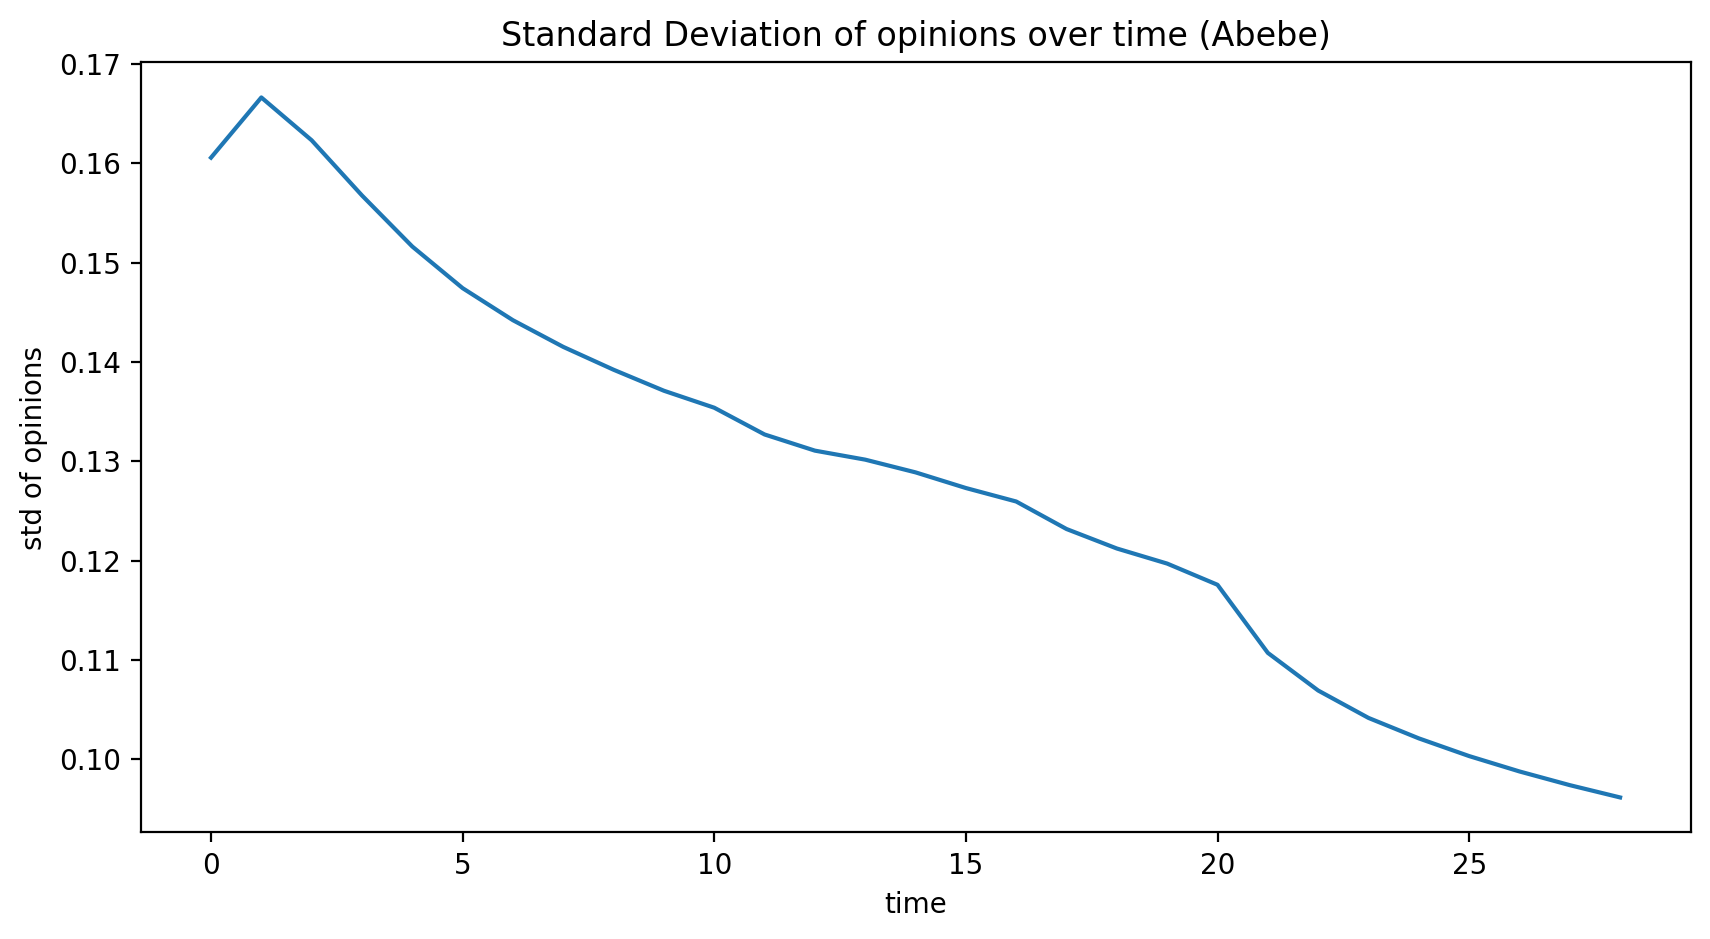

avgdiff_per_iter: [0.24478090084962034, 0.08093300188092953, 0.04002850801438291, 0.024116609163710636, 0.016622351889358764, 0.012811276115945472, 0.009920575472062798, 0.008583947160234308, 0.006773052775884346, 0.006150003770642878, 0.0068264770975044135, 0.008615272255022018, 0.0064619043120356205, 0.006005045015988243, 0.0057741833632965565, 0.005149544959480931, 0.00616930910793988, 0.008471126706676123, 0.00713463197313957, 0.007762513218164054, 0.007411417494310879, 0.011147671309816759, 0.014887299023160815, 0.010070788904220624, 0.007913886356078339, 0.006598246980244625, 0.005670305524840427, 0.004979828844180494, 0.0044400556316235825]
opinions_std_per_iter: [0.16060643759468904, 0.16670674471688354, 0.1626386256582548, 0.157271297740398, 0.15217537201376835, 0.14786270818746902, 0.1445031217083598, 0.14223757808259693, 0.14027363382830935, 0.13824583845711846, 0.13723319870626843, 0.13766365543311673, 0.1380266471390317, 0.138916839834234, 0.14000859717641684, 0.1408311518

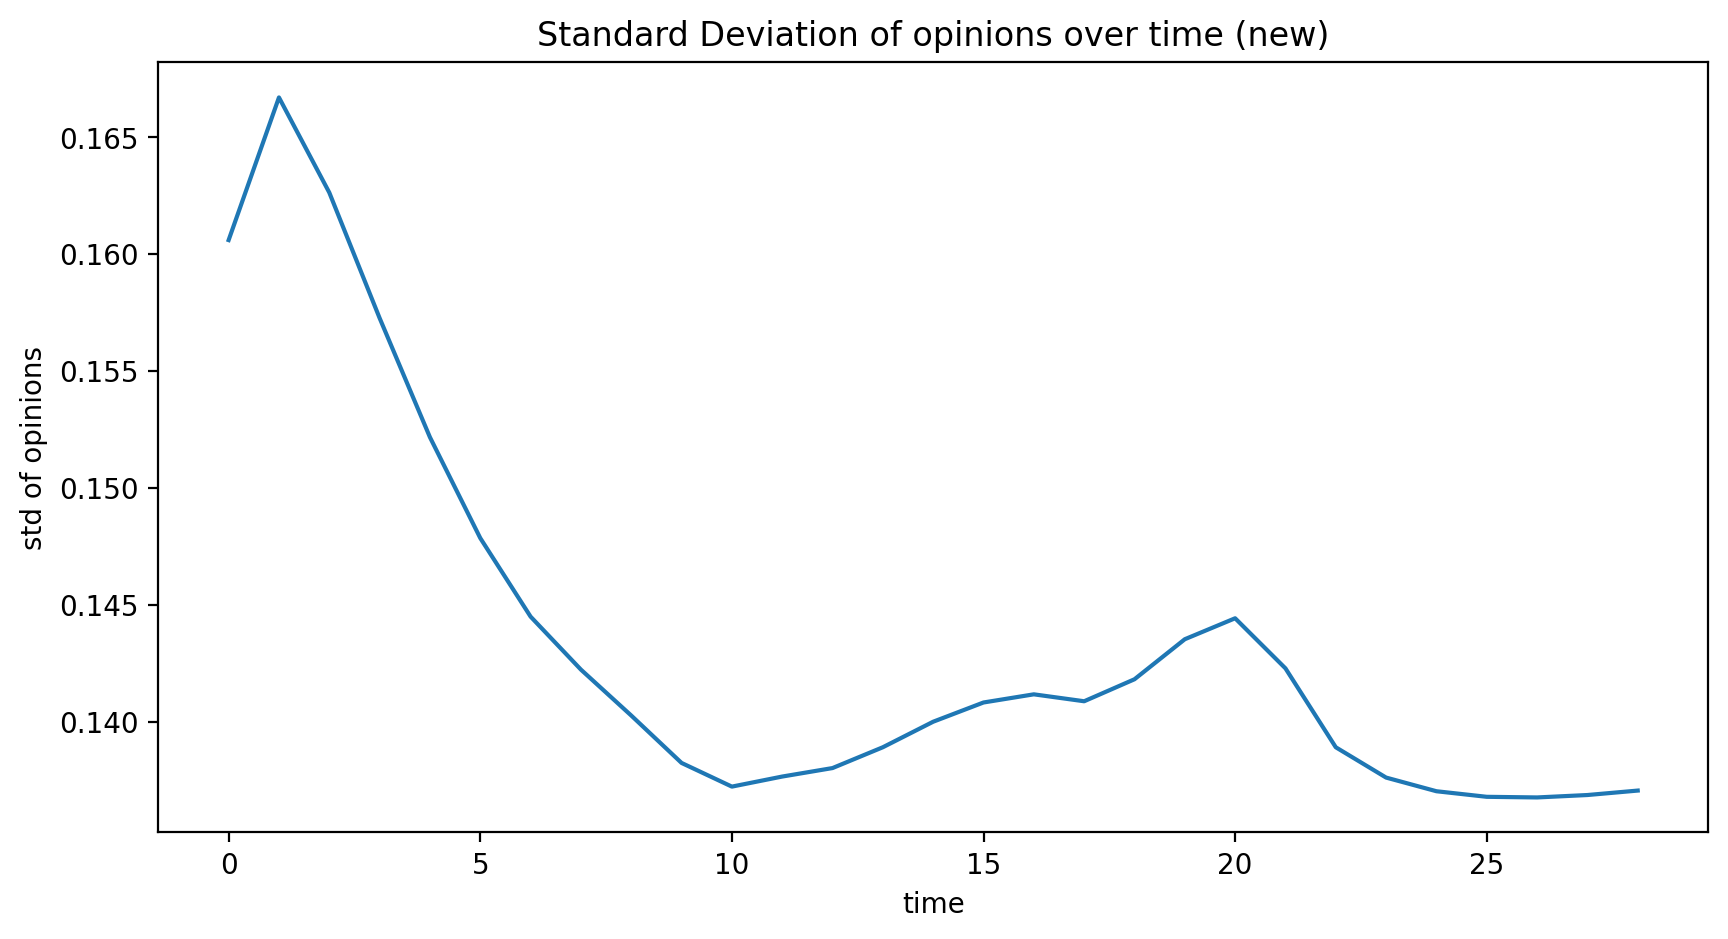

In [19]:
models = ['Abebe', 'new']  # mode = ['FJ', 'Abebe', 'new']
fig = go.Figure()

# read graph
_, g_init, init_date, df = read_combined_graph_from_csv(
    field='History',  # 'History' or 'Physics'
    init_cutoff_date='2019-03-01',
    graph=nx.Graph()  # nx.Graph() or nx.DiGraph()
)

# initialize attributes of the graph to test
test_graph = GraphAttributeClass().add_attrs(g=g_init)

# simulate
for model in models:
    # setup
    graph = test_graph.copy()
    test = ExperimentClass(graph, model, df, init_date)

    # Execute the model
    test.run_model(steps=30)

    # get results
    avgdiff_per_iter = test.get_avgdiff_per_iter()
    print(f"avgdiff_per_iter: {avgdiff_per_iter}")
    opinions_std_per_iter = test.get_opinions_std_per_iter()
    print(f"opinions_std_per_iter: {opinions_std_per_iter}")

    # plot the results
    test.plot()
    fig.add_trace(go.Scatter(x=np.arange(1, len(avgdiff_per_iter)+1), y=opinions_std_per_iter, mode='lines', name=f'{model}'))

# plot multiple models together
fig.update_layout(title='Opinions Std over time', 
                  xaxis_title='step', yaxis_title='Avg difference in opinions',
                  title_x=0.5, title_y=0.85,
                  legend=dict(
                      yanchor="top",
                      y=0.99,
                      xanchor="right",
                      x=0.99
                  ),
                  width=600, height=400)

# update x ticks to every 1
fig.update_xaxes(dtick=1)
fig.show()

# Save the figure with a high resolution (dpi=300)
pio.write_image(fig, 'avg_diff.jpeg', width=600, height=400, scale=10)


In [20]:
# only try this when having sufficient time and PC memory
'''plt.figure(figsize = (15,15))
nx.draw(g_simple, node_size=[g_simple.nodes[node]['node_centrality'] for node in g_simple.nodes],
    node_color=[g_simple.nodes[node]['opinion'] for node in g_simple.nodes])
plt.savefig('start.svg')'''

"plt.figure(figsize = (15,15))\nnx.draw(g_simple, node_size=[g_simple.nodes[node]['node_centrality'] for node in g_simple.nodes],\n    node_color=[g_simple.nodes[node]['opinion'] for node in g_simple.nodes])\nplt.savefig('start.svg')"

## Observe changes over time with subgraph

In [21]:
def extract_connected_subgraph(G, node_count=20):
    """
    Extracts a connected subgraph of approximately `node_count` nodes from the largest connected component of a graph `G`.

    Parameters:
    G (nx.Graph): The graph from which to extract the subgraph.
    node_count (int): The desired number of nodes in the subgraph.

    Returns:
    nx.Graph: A connected subgraph of `G`.
    """
    if G.is_directed():
        # Get the largest weakly connected component for directed graphs
        largest_cc = max(nx.weakly_connected_components(G), key=len)
    else:
        # Get the largest connected component for undirected graphs
        largest_cc = max(nx.connected_components(G), key=len)

    # Create a subgraph from the largest component
    subG = G.subgraph(largest_cc).copy()

    if subG.number_of_nodes() < node_count:
        # raise error
        print(f"Warning: The largest component of the graph has {subG.number_of_nodes()} nodes, which is smaller than the desired size of {node_count}.")
        # The largest component is already smaller than the desired size
        return subG

    # chose random one node
    central_node = np.random.choice(subG.nodes)
    # central_node = max(subG.degree, key=lambda x: x[1])[0]  # if you use the node with the highest degree

    # Start with a radius of 1 and increase until we get close to the desired node count
    radius = 1
    while True:
        ego_net = nx.ego_graph(subG, central_node, radius=radius)
        if ego_net.number_of_nodes() >= node_count:
            break
        radius += 1

    return ego_net.copy()


In [22]:
# read graph
g_final, g_init, init_date, df = read_combined_graph_from_csv(
  field='History',  # 'History' or 'Physics'
  init_cutoff_date='2019-03-01',
  graph=nx.Graph()  # nx.Graph() or nx.DiGraph()
)

# initialize attributes of the graph to test
g_with_attr = GraphAttributeClass().add_attrs(g=g_init)

# extract subgraph
subgraph = extract_connected_subgraph(g_with_attr, node_count=20)
try:
    print(f"is_connected: {nx.is_connected(subgraph)}")
except:
    print(f"is_connected: {nx.is_weakly_connected(subgraph)}")

is_connected: True


In [23]:
def plot_graph(
    nodes: list,
    graph: nx.Graph | nx.DiGraph,
    pos,
    index=0,
    node_size_scale=10) -> None:
    """
    plot graph with fixed position
    """

    # set a continuous color scale to map opinions to colors
    plt.figure(figsize=(4, 4))
    cmap = plt.cm.get_cmap('coolwarm')

    # set node size and color according to node centrality and opinion
    node_sizes = [graph.nodes[node]['node_centrality']*node_size_scale for node in nodes]
    node_colors = [cmap(graph.nodes[node]['opinion']) for node in nodes]

    # always draw the nodes in the same place
    nx.draw(graph.subgraph(nodes), pos=pos, node_size=node_sizes, node_color=node_colors, width=1, edge_color='black')
    # plt.savefig(f'figures/opinion_{index}.jpeg', dpi=300)


/tmp/ipykernel_2860344/1921677816.py:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



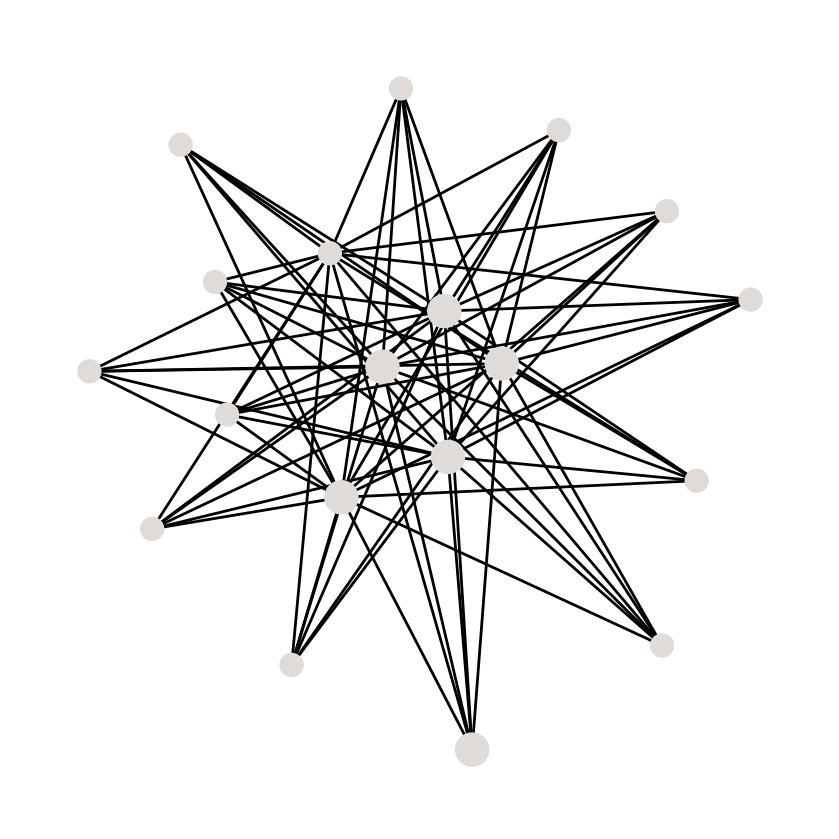

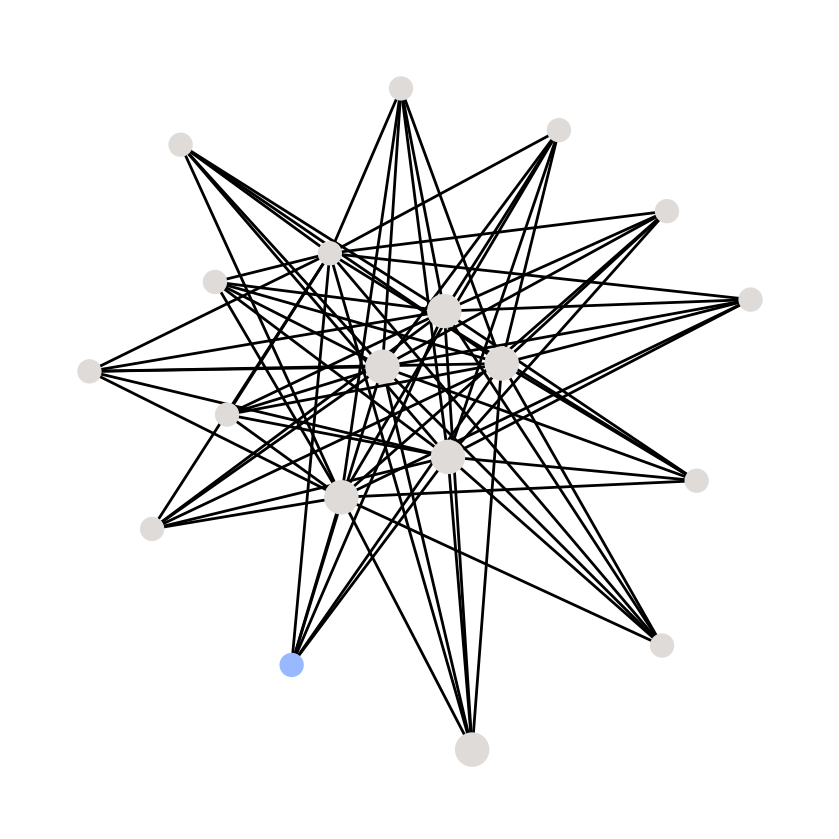

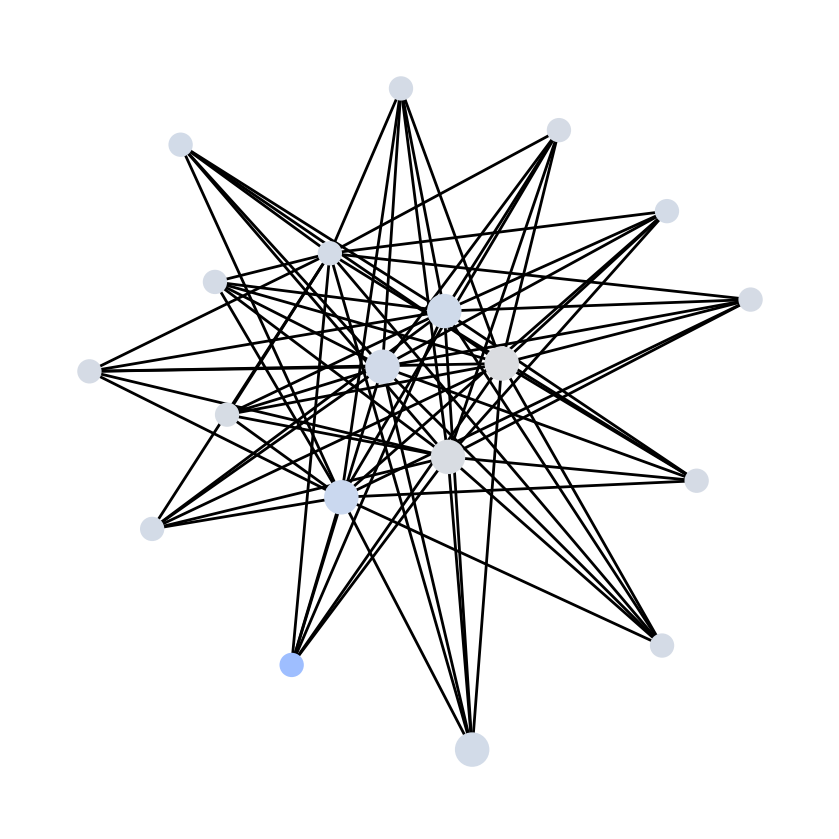

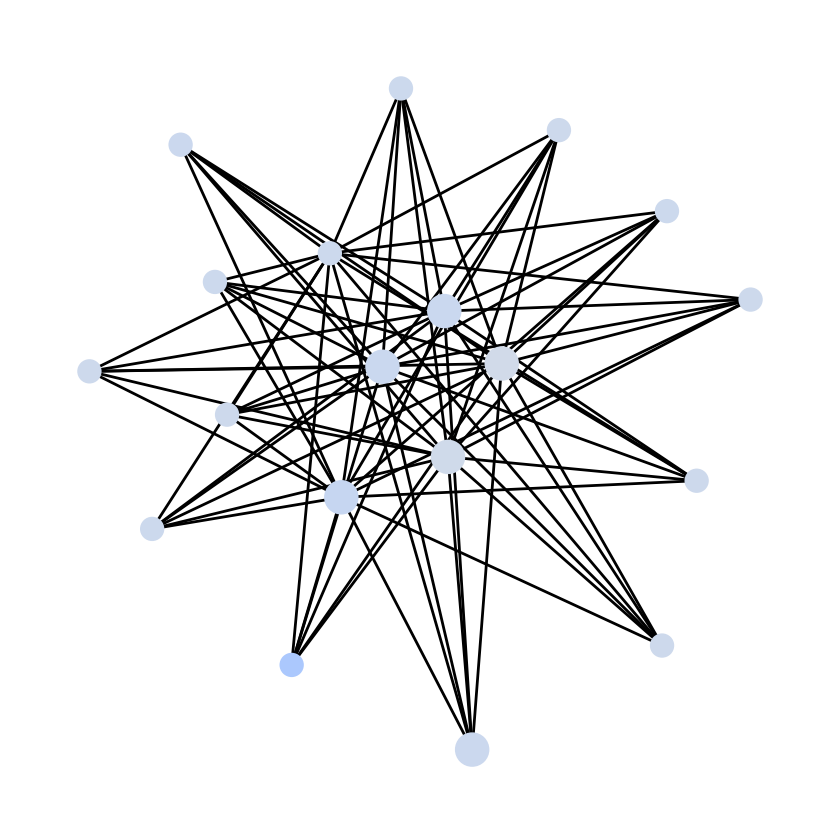

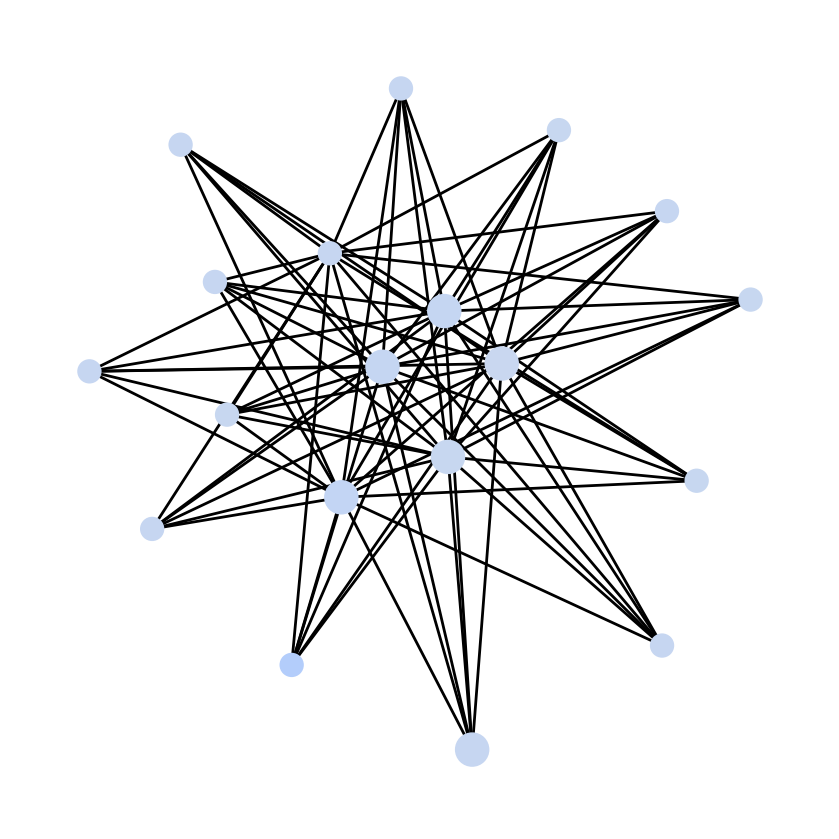

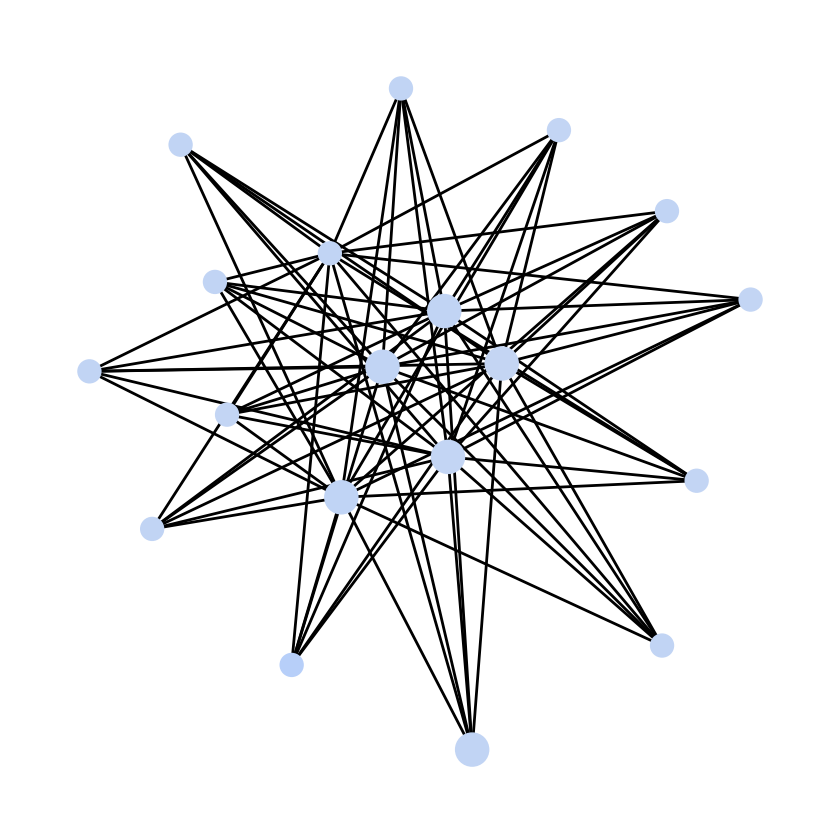

In [24]:
%config InlineBackend.figure_format = 'retina'
model = 'Abebe'
test = ExperimentClass(graph, model, df, init_date)

# fixed nodes and position
pos = nx.spring_layout(subgraph)
nodes = list(subgraph.nodes())

# draw initial state
plot_graph(nodes, test_graph, pos, index=0, node_size_scale=10)

cnt = 1
while cnt <= 5:
    # run simulate
    test.run_model(20*cnt)
    # plot graph
    plot_graph(nodes, test.graph, pos, index=cnt, node_size_scale=10)
    cnt += 1
